Data loading

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import regex as re
import pandas as pd
import numpy as np
import math
import os 


file_name = 'cumulative_dataset'
# file_name = 'windowed_30d_dataset'
# file_name = 'windowed_90d_dataset'
# file_name = 'windowed_180d_dataset'
# file_name = 'windowed_365d_dataset'

file_name = "training_dataset_windowed_days_90"
data_path = f'/workspaces/msc_thesis/data/final_data/{file_name}.csv'

df:pd.DataFrame = pd.read_csv(filepath_or_buffer=data_path, header=0)


print(f'Total entries: {len(df)}.')

print(f'{df.columns=}')

df.describe()

# The number of headers containing metadata; i.e., the stuff that's unusable for inference.
meta_header_count = 4
pr_merged_key = 'PullRequestIsMerged'


Total entries: 1848492.
df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestLifeTimeInMinutes',
       'ControlPullRequestHasComments', 'ControlNumberOfCommitsInPullRequest',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestExperienceOfIntegrator',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSubmissionCount',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterEcosystemExperiencePullRequestCommentCount',
       'SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount',
       'SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator',
       'SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter',
       'SharedExperiencePullRequestSubmittedB

Drop irrelevant fields and perform log-transform on the relevant fields.

In [2]:
removed_fields = [
    "SharedExperienceIssueDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperienceIssueSubmittedBySubmitterCommentedOnByIntegrator",
    "SharedExperiencePullRequestDiscussionParticipationByIntegratorAndSubmitter",
    "SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterCommentedOnByIntegrator",

    "SubmitterDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterDependencyEcosystemExperienceIssueSubmissionCount",

    "SubmitterDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperienceIssueDiscussionParticipationCount",  # duplicate
    "SubmitterEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate

    "SubmitterInversedDependencyEcosystemExperienceIssueCommentCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueDiscussionParticipationCount",
    "SubmitterInversedDependencyEcosystemExperienceIssueSubmissionCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestDiscussionParticipationCount",  # duplicate


]

log_transformed_fields = [
    "ControlIntraProjectPullRequestExperienceOfIntegrator",
    # "ControlIntraProjectPullRequestSuccessRateSubmitter", # ratio variable
    "ControlNumberOfCommitsInPullRequest",  # mega skewed
    "ControlPullRequestLifeTimeInMinutes",

    "SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter",
    "SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator",

    "SubmitterDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount",
    # "SubmitterDependencyEcosystemExperiencePullRequestSuccessRate", # ratio variable

    "SubmitterEcosystemExperienceIssueCommentCount",
    "SubmitterEcosystemExperienceIssueSubmissionCount",
    "SubmitterEcosystemExperiencePullRequestCommentCount",
    "SubmitterEcosystemExperiencePullRequestSubmissionCount",
    # "SubmitterEcosystemExperiencePullRequestSuccessRate", # ratio variable

    "SubmitterInversedDependencyEcosystemExperiencePullRequestCommentCount",
    "SubmitterInversedDependencyEcosystemExperiencePullRequestSubmissionCount",
    # "SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate" # ratio variable
]

binary_fields = [
    "ControlHasHashTagInDescription",
    "ControlIntegratedBySameUser",
    "ControlPullRequestHasCommentByExternalUser",
    "ControlPullRequestHasComments",
    "SubmitterIsFirstTimeContributor",
]

print(f'{len(removed_fields)=}')
print(f'{len(log_transformed_fields)=}')
print(f'{len(binary_fields)=}')

df = df.drop(removed_fields, axis=1)

for field in log_transformed_fields:
    df[f'log10(1 + {field})'] = np.log10(1 + df[field])
    df = df.drop(field, axis=1)

print(f'{df.columns=}')
print(f'{df.columns[df.isna().any()].tolist()=}')
df = df.dropna()


len(removed_fields)=15
len(log_transformed_fields)=13
len(binary_fields)=5


/home/vscode/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


df.columns=Index(['ID', 'Project Name', 'PR Number', 'Closed At',
       'ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'PullRequestIsMerged',
       'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterDependencyEcosystemExperiencePullRequestSuccessRate',
       'SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate',
       'SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1',
       'log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'log10(1 + ControlNumberOfCommitsInPullRequest)',
       'log10(1 + ControlPullRequestLifeTimeInMinutes)',
       'log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'log10(1 + SharedExperiencePullRequestSubmittedBySubmitterInteg

Downsamples the majority class to account for class imbalance.

In [3]:
class_counts = df[pr_merged_key].value_counts()

print(f'{class_counts=}')
class_imbalance = max(class_counts) / min(class_counts)
print(f'Class imbalance: {class_imbalance:.03f}.')

# optional.
do_resample = False
if do_resample:
    from sklearn.utils import resample


    majority = df[df.DepPRIsMerged]
    minority = df[df.DepPRIsMerged == False]

    majority = resample(majority, replace=True,
                        n_samples=len(minority), random_state=0)

    df = pd.concat([majority, minority])

    print(f'Resampled size: {len(df)}.')

class_counts=PullRequestIsMerged
True     1422696
False     425787
Name: count, dtype: int64
Class imbalance: 3.341.


Downsamples the dataset in case you set ``sample`` to ``>0``.

In [4]:
sample_size = 0
if sample_size > 0:
    df = df.sample(sample_size)
    print("WARNING: TRAINING WITH SAMPLE!")

Creates train and test data.

In [5]:
train, test = train_test_split(df, test_size=0.2)
print(
    f'Training with {len(train)} entries and testing with {len(test)} entries.')

Training with 1478786 entries and testing with 369697 entries.


Selects predictor features and the dependent feature.

In [6]:
train_labels = train[pr_merged_key]
test_labels = test[pr_merged_key]
all_labels = df[pr_merged_key]

used_predictors: pd.Index = df.columns[meta_header_count:]
used_predictors = used_predictors.drop(pr_merged_key)

print(f'{used_predictors=}')

train_predictors = train[used_predictors]
test_predictors = test[used_predictors]
all_predictors = df[used_predictors]

print(df)

used_predictors=Index(['ControlIntegratedBySameUser', 'ControlPullRequestHasComments',
       'ControlPullRequestHasCommentByExternalUser',
       'ControlHasHashTagInDescription', 'SubmitterIsFirstTimeContributor',
       'ControlIntraProjectPullRequestSuccessRateSubmitter',
       'SubmitterEcosystemExperiencePullRequestSuccessRate',
       'SubmitterDependencyEcosystemExperiencePullRequestSuccessRate',
       'SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate',
       'SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1',
       'log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)',
       'log10(1 + ControlNumberOfCommitsInPullRequest)',
       'log10(1 + ControlPullRequestLifeTimeInMinutes)',
       'log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)',
       'log10(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)',
       'log10(1 + SubmitterDependencyEcosystemExperiencePul

## Random Forest

In [7]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
seed = 42
rf = RandomForestRegressor(100, random_state=seed)

rf.fit(train_predictors, train_labels)

predictions = rf.predict(test_predictors)
predictions = [pred >= 0.5 for pred in predictions]

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')

conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

imbalance_weight = list([1.0 if label else class_imbalance for label in test_labels])
f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))


Generates partial dependence plots.

It's visible that the intra-project experience completely overshadows other factors. 

When exclusing this, you can see that PR acceptance ratio matters as well as whether the PR has comments. 
Lifetime somehow has no effect whatsoever; ditto for the ecosystem PR count. 

23
ControlIntegratedBySameUser
ControlPullRequestHasComments
ControlPullRequestHasCommentByExternalUser
ControlHasHashTagInDescription
SubmitterIsFirstTimeContributor
ControlIntraProjectPullRequestSuccessRateSubmitter
SubmitterEcosystemExperiencePullRequestSuccessRate
SubmitterDependencyEcosystemExperiencePullRequestSuccessRate
SubmitterInversedDependencyEcosystemExperiencePullRequestSuccessRate
SharedExperiencePullRequestSubmittedByIntegratorCommentedOnBySubmitter.1
log10(1 + ControlIntraProjectPullRequestExperienceOfIntegrator)
log10(1 + ControlNumberOfCommitsInPullRequest)
log10(1 + ControlPullRequestLifeTimeInMinutes)
log10(1 + SharedExperiencePullRequestSubmittedByIntegratorIntegratedBySubmitter)
log10(1 + SharedExperiencePullRequestSubmittedBySubmitterIntegratedByIntegrator)
log10(1 + SubmitterDependencyEcosystemExperiencePullRequestCommentCount)
log10(1 + SubmitterDependencyEcosystemExperiencePullRequestSubmissionCount)
log10(1 + SubmitterEcosystemExperienceIssueCommentCount)
lo

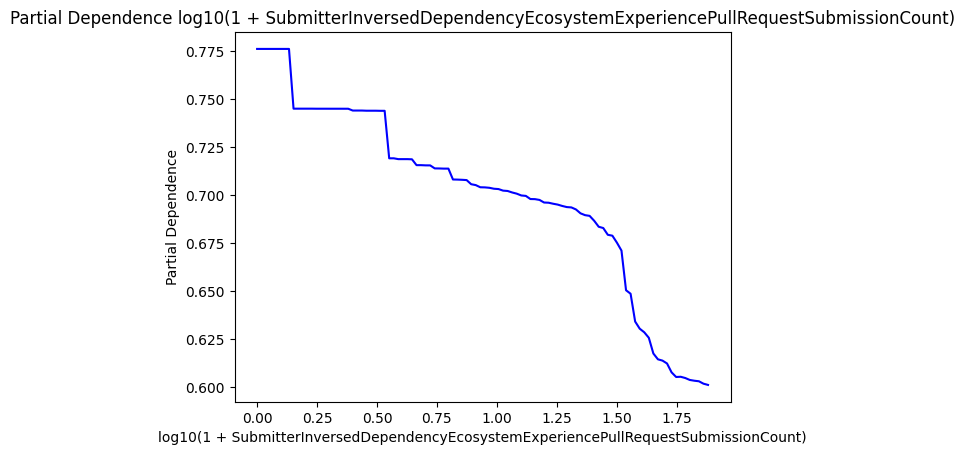

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
from matplotlib import pyplot as plt

# Collective partial dependence plot.
pdd = PartialDependenceDisplay.from_estimator(rf, test_predictors, used_predictors)

fig = plt.gcf()
axs = fig.axes

lines = []
for ax in axs:
    __lines = list([(line.get_xdata(), line.get_ydata()) for line in ax.lines]) 
    lines.extend(__lines)


print(len(lines))

plt.cla()
plt.clf()

base_path = "/workspaces/msc_thesis/data/figures/partial-dependence/"
for (x, y), label in zip(lines, used_predictors):
    print(label)
    plt.clf()

    # Create a line chart
    plt.plot(x, y, linestyle='-', color='blue')

    # Add labels and title
    plt.xlabel(label)
    plt.ylabel('Partial Dependence')
    plt.title(f'Partial Dependence {label}')
    plt.savefig(f'{base_path}/{label}.png')


if not os.path.exists(base_path):
    os.makedirs(base_path)

In [ ]:
# Disabled as this takes forever.
# # Individual partial dependence plot.
# PartialDependenceDisplay.from_estimator(
#     rf, test_predictors, used_predictors, kind='individual')

# fig = plt.gcf()
# fig.set_figwidth(12)
# fig.set_figheight(6)
# fig.subplots_adjust(left=0.1,
#                     bottom=0.1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.15,
#                     hspace=0.3)


## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(train_predictors, train_labels)

lr_predictions = lr.predict(test_predictors)

imbalance_weight = [1.0 if label else class_imbalance for label in test_labels]
score = lr.score(test_predictors, test_labels, sample_weight=imbalance_weight)

print(f'{score=}')

errors = abs(predictions ^ test_labels)

print(f'Absolute error: {errors}')


conf = confusion_matrix(test_labels, predictions)
print(f'{conf=}')

f1 = f1_score(test_labels, predictions, sample_weight=imbalance_weight)
print(f'{f1=}')

print(classification_report(test_labels, predictions, sample_weight=imbalance_weight))

score=0.6733061518862977
Absolute error: 21496      False
1609245     True
779837     False
169715     False
1310049    False
           ...  
1309327    False
337887     False
472215     False
1811290    False
1336931    False
Name: PullRequestIsMerged, Length: 20000, dtype: bool
conf=array([[ 2698,  1867],
       [  849, 14586]])
f1=0.8045391311125885
              precision    recall  f1-score   support

       False       0.91      0.59      0.72 15253.183493155631
        True       0.70      0.94      0.80   15435.0

    accuracy                           0.77 30688.18349315563
   macro avg       0.81      0.77      0.76 30688.18349315563
weighted avg       0.81      0.77      0.76 30688.18349315563



Calculates corresponding p-values for each feature.

In [ ]:
import statsmodels.api as sm

value_mapper = {False: 0, True: 1}
for feature in binary_fields:
    train_predictors[feature] = train_predictors[feature].replace(value_mapper)
    test_predictors[feature] = test_predictors[feature].replace(value_mapper)
    
sm_lr = sm.Logit(train_labels, train_predictors[used_predictors])
result = sm_lr.fit()

print(result.params)

predictions = result.predict(test_predictors[used_predictors])
predictions = [pred >= 0.5 for pred in predictions]

result.pred_table()

print('summary 1:')
result.summary()

print('summary 2:')
result.summary2()


/tmp/ipykernel_10896/1675169009.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_predictors[feature] = train_predictors[feature].replace(value_mapper)
/tmp/ipykernel_10896/1675169009.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_predictors[feature] = test_predictors[feature].replace(value_mapper)


Optimization terminated successfully.
         Current function value: 0.414148
         Iterations 7


LinAlgError: Singular matrix